In [5]:
import random
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import pandas as pd
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data
import matplotlib.pyplot as plt
import math
import scienceplots
import matplotlib as mpl
from tqdm import tqdm

In [7]:
#1#: 第一步看sigmoid函数的过拟合情况
SEED = 1234#固定种子
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True

x = torch.unsqueeze(torch.linspace(-2, 10, 19), dim=1)
y = np.exp(-(x - 2)**2) + np.exp(-(x - 6)**2/10) + 1/ (x**2+1) + 0.12*torch.randn(x.size())  # 这里是污染数据固定不变当成训练数据

class Net(torch.nn.Module):  # 定义网络
    def __init__(self, n_feature, n_hidden1, n_output):
        super(Net, self).__init__()
        self.hidden1 = torch.nn.Linear(n_feature, n_hidden1)  # 全连接层
        self.predict = torch.nn.Linear(n_hidden1, n_output)   # 输出层

    def forward(self, x):
        x = self.hidden1(x)
        x = torch.sigmoid(x)
        x = self.predict(x)  # 前向传播过程
        return x
#经典的sigmoid神经网络1*n_hidden1*1，中间隐层为sigmoid函数

net = Net(n_feature=1, n_hidden1=14, n_output=1)
device = torch.device('cpu')#cpu计算就足够了，不是图像数据，所以不用GPU
optimizer = torch.optim.Adam(net.parameters(), lr=0.01, betas=(0.99,0.99))
#Adam算法，学习率是固定的0.01，矩参数是0.96

loss_func = torch.nn.MSELoss().to(device)  # loss函数是均方误差mse
x = x.to(device)
y = y.to(device)#把数据都载入到device上

In [7]:
# 假设 'net', 'x', 'y', 'loss_func', 和 'optimizer' 已经定义
epoch = 15000  # 训练次数
para0 = torch.zeros(epoch)  # 记录训练时每个epoch的loss函数值

# 固定随机种子
seeds = random.sample(range(1, 10000), 10)  # 生成10个随机种子
validation_epochs=[]
para1 = []
def test_with_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    xxx = torch.unsqueeze(torch.linspace(-2, 10, 30), dim=1)
    yyy = np.exp(-(xxx - 2)**2) + np.exp(-(xxx - 6)**2/10) + 1/ (xxx**2+1) + 0.12*torch.randn(xxx.size())
    predictiont = net(xxx)  # 前向过程
    losstest = loss_func(predictiont, yyy)  # 计算loss，通过prediction和y的差来计算mse
    return losstest.data.item()

# 开始训练和验证
for t in tqdm(range(epoch), desc="Training Progress"):#它将进度条的描述信息设置为“Training Progress”
    prediction = net(x)  # 网络前向过程
    loss = loss_func(prediction, y)  # 计算loss，通过prediction和y的差来计算mse
    para0[t] = loss.data

    optimizer.zero_grad()  # 清除下一次训练的梯度
    loss.backward(retain_graph=True)  # 反向传播！retain_graph=True主要是为了多次反向传播保留计算图，这里可能是防止报错
    optimizer.step()  # 更新参数
    
    # 验证并记录平均loss#每隔100次用10组数据进行了验证
    if t == 0 or (t + 1) % 100 == 0:
        validation_epochs.append(t + 1)
        losses = [test_with_seed(seed) for seed in seeds]
        average_loss = sum(losses) / len(losses)
        para1.append(average_loss)
        print(f'Epoch {t + 1}: Validation Average Loss = {average_loss}')

Training Progress:   1%|▍                                                         | 100/15000 [00:00<00:16, 928.33it/s]

Epoch 1: Validation Average Loss = 0.7527274250984192
Epoch 100: Validation Average Loss = 0.09970622286200523
Epoch 200: Validation Average Loss = 0.10614802688360214


Training Progress:   3%|█▊                                                       | 474/15000 [00:00<00:12, 1188.27it/s]

Epoch 300: Validation Average Loss = 0.05755400732159614
Epoch 400: Validation Average Loss = 0.0492771252989769
Epoch 500: Validation Average Loss = 0.045120982080698015


Training Progress:   5%|███                                                      | 819/15000 [00:00<00:13, 1068.66it/s]

Epoch 600: Validation Average Loss = 0.042266587167978285
Epoch 700: Validation Average Loss = 0.040767353400588034
Epoch 800: Validation Average Loss = 0.04016594272106886


Training Progress:   7%|███▉                                                    | 1056/15000 [00:00<00:12, 1119.58it/s]

Epoch 900: Validation Average Loss = 0.03902753237634897
Epoch 1000: Validation Average Loss = 0.037973214872181416
Epoch 1100: Validation Average Loss = 0.036937829665839673


Training Progress:   9%|█████▎                                                  | 1416/15000 [00:01<00:11, 1135.01it/s]

Epoch 1200: Validation Average Loss = 0.03609013725072145
Epoch 1300: Validation Average Loss = 0.035121774114668367
Epoch 1400: Validation Average Loss = 0.03363776337355375


Training Progress:  11%|██████▏                                                 | 1646/15000 [00:01<00:11, 1134.75it/s]

Epoch 1500: Validation Average Loss = 0.029110937751829623
Epoch 1600: Validation Average Loss = 0.02417981717735529
Epoch 1700: Validation Average Loss = 0.02046267781406641


Training Progress:  13%|███████                                                 | 1899/15000 [00:01<00:11, 1186.68it/s]

Epoch 1800: Validation Average Loss = 0.01960909627377987
Epoch 1900: Validation Average Loss = 0.018190843425691126


Training Progress:  14%|████████                                                | 2143/15000 [00:01<00:11, 1161.93it/s]

Epoch 2000: Validation Average Loss = 0.017635743506252764
Epoch 2100: Validation Average Loss = 0.017489406652748583
Epoch 2200: Validation Average Loss = 0.017448823153972625


Training Progress:  16%|████████▉                                               | 2404/15000 [00:02<00:10, 1152.28it/s]

Epoch 2300: Validation Average Loss = 0.017231935635209084
Epoch 2400: Validation Average Loss = 0.017386055458337067
Epoch 2500: Validation Average Loss = 0.017378889303654433


Training Progress:  19%|██████████▍                                             | 2798/15000 [00:02<00:11, 1070.85it/s]

Epoch 2600: Validation Average Loss = 0.017391924001276492
Epoch 2700: Validation Average Loss = 0.017547760996967553


Training Progress:  19%|██████████▊                                             | 2910/15000 [00:02<00:11, 1029.55it/s]

Epoch 2800: Validation Average Loss = 0.01758599476888776
Epoch 2900: Validation Average Loss = 0.017769357562065123
Epoch 3000: Validation Average Loss = 0.017840175051242115


Training Progress:  22%|████████████▎                                           | 3291/15000 [00:02<00:10, 1160.61it/s]

Epoch 3100: Validation Average Loss = 0.017939142789691685
Epoch 3200: Validation Average Loss = 0.018071317207068206
Epoch 3300: Validation Average Loss = 0.018232732173055412


Training Progress:  24%|█████████████▌                                          | 3632/15000 [00:03<00:10, 1093.75it/s]

Epoch 3400: Validation Average Loss = 0.01827925452962518
Epoch 3500: Validation Average Loss = 0.01849554255604744
Epoch 3600: Validation Average Loss = 0.018650105129927395


Training Progress:  26%|██████████████▍                                         | 3853/15000 [00:03<00:10, 1058.67it/s]

Epoch 3700: Validation Average Loss = 0.018783690594136714
Epoch 3800: Validation Average Loss = 0.019119380321353675
Epoch 3900: Validation Average Loss = 0.019487332738935947


Training Progress:  28%|███████████████▊                                        | 4223/15000 [00:03<00:09, 1142.41it/s]

Epoch 4000: Validation Average Loss = 0.020038735028356312
Epoch 4100: Validation Average Loss = 0.0206628168001771
Epoch 4200: Validation Average Loss = 0.021488757338374853


Training Progress:  30%|████████████████▊                                       | 4494/15000 [00:03<00:08, 1232.26it/s]

Epoch 4300: Validation Average Loss = 0.022621692437678576
Epoch 4400: Validation Average Loss = 0.023847650177776812
Epoch 4500: Validation Average Loss = 0.025177084561437368


Training Progress:  32%|█████████████████▋                                      | 4736/15000 [00:04<00:09, 1109.96it/s]

Epoch 4600: Validation Average Loss = 0.026591031812131405
Epoch 4700: Validation Average Loss = 0.02803992070257664


Training Progress:  33%|██████████████████▌                                     | 4980/15000 [00:04<00:08, 1159.29it/s]

Epoch 4800: Validation Average Loss = 0.02921061497181654
Epoch 4900: Validation Average Loss = 0.03036872260272503
Epoch 5000: Validation Average Loss = 0.031200003065168857


Training Progress:  35%|███████████████████▍                                    | 5220/15000 [00:04<00:08, 1164.42it/s]

Epoch 5100: Validation Average Loss = 0.031774953566491605
Epoch 5200: Validation Average Loss = 0.0322872243821621
Epoch 5300: Validation Average Loss = 0.0326211255043745


Training Progress:  37%|████████████████████▉                                   | 5592/15000 [00:04<00:08, 1156.02it/s]

Epoch 5400: Validation Average Loss = 0.0330395121127367
Epoch 5500: Validation Average Loss = 0.03331985399127006
Epoch 5600: Validation Average Loss = 0.03371568117290735


Training Progress:  39%|█████████████████████▊                                  | 5845/15000 [00:05<00:08, 1134.55it/s]

Epoch 5700: Validation Average Loss = 0.034050728753209115
Epoch 5800: Validation Average Loss = 0.03439578339457512
Epoch 5900: Validation Average Loss = 0.034559919871389864


Training Progress:  41%|███████████████████████▏                                | 6224/15000 [00:05<00:07, 1183.86it/s]

Epoch 6000: Validation Average Loss = 0.03490320332348347
Epoch 6100: Validation Average Loss = 0.03506714105606079
Epoch 6200: Validation Average Loss = 0.03540270421653986


Training Progress:  43%|████████████████████████▏                               | 6482/15000 [00:05<00:06, 1227.63it/s]

Epoch 6300: Validation Average Loss = 0.0355663163587451
Epoch 6400: Validation Average Loss = 0.03588981125503778
Epoch 6500: Validation Average Loss = 0.036100471206009385


Training Progress:  46%|█████████████████████████▌                              | 6846/15000 [00:05<00:06, 1182.24it/s]

Epoch 6600: Validation Average Loss = 0.03629649560898542
Epoch 6700: Validation Average Loss = 0.03661629427224398
Epoch 6800: Validation Average Loss = 0.03680038899183273


Training Progress:  47%|██████████████████████████▍                             | 7084/15000 [00:06<00:06, 1164.15it/s]

Epoch 6900: Validation Average Loss = 0.036996322497725484
Epoch 7000: Validation Average Loss = 0.037262560613453385
Epoch 7100: Validation Average Loss = 0.037509605102241037


Training Progress:  49%|███████████████████████████▎                            | 7316/15000 [00:06<00:06, 1125.75it/s]

Epoch 7200: Validation Average Loss = 0.03770836088806391
Epoch 7300: Validation Average Loss = 0.03783626314252615
Epoch 7400: Validation Average Loss = 0.03793856650590897


Training Progress:  51%|████████████████████████████▊                           | 7717/15000 [00:06<00:06, 1122.59it/s]

Epoch 7500: Validation Average Loss = 0.03813680279999972
Epoch 7600: Validation Average Loss = 0.03830239437520504
Epoch 7700: Validation Average Loss = 0.038385740108788015


Training Progress:  53%|█████████████████████████████▊                          | 7970/15000 [00:06<00:05, 1177.92it/s]

Epoch 7800: Validation Average Loss = 0.038500604778528215
Epoch 7900: Validation Average Loss = 0.038643657602369784
Epoch 8000: Validation Average Loss = 0.03874313980340958


Training Progress:  55%|██████████████████████████████▋                         | 8209/15000 [00:07<00:06, 1103.31it/s]

Epoch 8100: Validation Average Loss = 0.03887021020054817
Epoch 8200: Validation Average Loss = 0.03893869183957577


Training Progress:  56%|███████████████████████████████▌                        | 8462/15000 [00:07<00:05, 1168.78it/s]

Epoch 8300: Validation Average Loss = 0.03903045132756233
Epoch 8400: Validation Average Loss = 0.039118494093418124
Epoch 8500: Validation Average Loss = 0.039160297624766825


Training Progress:  59%|█████████████████████████████████                       | 8849/15000 [00:07<00:05, 1229.19it/s]

Epoch 8600: Validation Average Loss = 0.03918262757360935
Epoch 8700: Validation Average Loss = 0.039134097099304196
Epoch 8800: Validation Average Loss = 0.03914347477257252


Training Progress:  61%|█████████████████████████████████▉                      | 9095/15000 [00:07<00:04, 1194.19it/s]

Epoch 8900: Validation Average Loss = 0.03913367595523596
Epoch 9000: Validation Average Loss = 0.039072001725435256
Epoch 9100: Validation Average Loss = 0.03902815822511911


Training Progress:  62%|██████████████████████████████████▊                     | 9326/15000 [00:08<00:05, 1081.57it/s]

Epoch 9200: Validation Average Loss = 0.038939297944307324
Epoch 9300: Validation Average Loss = 0.03881875220686197
Epoch 9400: Validation Average Loss = 0.038690687716007234


Training Progress:  64%|████████████████████████████████████                    | 9659/15000 [00:08<00:04, 1072.77it/s]

Epoch 9500: Validation Average Loss = 0.03856158312410116
Epoch 9600: Validation Average Loss = 0.038414026238024236
Epoch 9700: Validation Average Loss = 0.03825651817023754


Training Progress:  67%|████████████████████████████████████▋                  | 10000/15000 [00:08<00:04, 1068.85it/s]

Epoch 9800: Validation Average Loss = 0.03805726207792759
Epoch 9900: Validation Average Loss = 0.03784689735621214
Epoch 10000: Validation Average Loss = 0.03760111853480339


Training Progress:  68%|█████████████████████████████████████▌                 | 10256/15000 [00:09<00:04, 1141.85it/s]

Epoch 10100: Validation Average Loss = 0.03729376196861267
Epoch 10200: Validation Average Loss = 0.036956145986914636
Epoch 10300: Validation Average Loss = 0.03658987712115049


Training Progress:  70%|██████████████████████████████████████▌                | 10500/15000 [00:09<00:03, 1159.31it/s]

Epoch 10400: Validation Average Loss = 0.036220216751098634
Epoch 10500: Validation Average Loss = 0.03582737538963556
Epoch 10600: Validation Average Loss = 0.03543534632772207


Training Progress:  73%|███████████████████████████████████████▉               | 10900/15000 [00:09<00:03, 1228.54it/s]

Epoch 10700: Validation Average Loss = 0.035051862522959706
Epoch 10800: Validation Average Loss = 0.03472086973488331
Epoch 10900: Validation Average Loss = 0.03444391116499901


Training Progress:  74%|████████████████████████████████████████▉              | 11155/15000 [00:09<00:03, 1240.74it/s]

Epoch 11000: Validation Average Loss = 0.0342347102239728
Epoch 11100: Validation Average Loss = 0.034112822636961936
Epoch 11200: Validation Average Loss = 0.03409485090523958


Training Progress:  76%|█████████████████████████████████████████▉             | 11422/15000 [00:09<00:02, 1225.46it/s]

Epoch 11300: Validation Average Loss = 0.034175214171409604
Epoch 11400: Validation Average Loss = 0.034216251038014886
Epoch 11500: Validation Average Loss = 0.03433816973119974


Training Progress:  79%|███████████████████████████████████████████▎           | 11797/15000 [00:10<00:02, 1207.22it/s]

Epoch 11600: Validation Average Loss = 0.03455539457499981
Epoch 11700: Validation Average Loss = 0.034734195284545424
Epoch 11800: Validation Average Loss = 0.03496306035667658


Training Progress:  81%|████████████████████████████████████████████▌          | 12156/15000 [00:10<00:02, 1163.05it/s]

Epoch 11900: Validation Average Loss = 0.035129140503704546
Epoch 12000: Validation Average Loss = 0.035295434296131134
Epoch 12100: Validation Average Loss = 0.03542674332857132


Training Progress:  83%|█████████████████████████████████████████████▍         | 12397/15000 [00:10<00:02, 1105.30it/s]

Epoch 12200: Validation Average Loss = 0.035585445910692216
Epoch 12300: Validation Average Loss = 0.03576390463858843
Epoch 12400: Validation Average Loss = 0.03589826431125402


Training Progress:  84%|██████████████████████████████████████████████▎        | 12629/15000 [00:11<00:02, 1134.09it/s]

Epoch 12500: Validation Average Loss = 0.035911967419087885
Epoch 12600: Validation Average Loss = 0.03598455041646957
Epoch 12700: Validation Average Loss = 0.03601580858230591


Training Progress:  87%|███████████████████████████████████████████████▌       | 12981/15000 [00:11<00:01, 1130.75it/s]

Epoch 12800: Validation Average Loss = 0.03593061827123165
Epoch 12900: Validation Average Loss = 0.035953701473772526
Epoch 13000: Validation Average Loss = 0.03595621250569821


Training Progress:  89%|████████████████████████████████████████████████▉      | 13338/15000 [00:11<00:01, 1123.77it/s]

Epoch 13100: Validation Average Loss = 0.03593550082296133
Epoch 13200: Validation Average Loss = 0.03611994367092848
Epoch 13300: Validation Average Loss = 0.03625613879412413


Training Progress:  90%|█████████████████████████████████████████████████▋     | 13565/15000 [00:11<00:01, 1101.48it/s]

Epoch 13400: Validation Average Loss = 0.03645073100924492
Epoch 13500: Validation Average Loss = 0.036778100021183494
Epoch 13600: Validation Average Loss = 0.03700403682887554


Training Progress:  93%|██████████████████████████████████████████████████▉    | 13889/15000 [00:12<00:01, 1036.65it/s]

Epoch 13700: Validation Average Loss = 0.03741554208099842
Epoch 13800: Validation Average Loss = 0.03781708031892776
Epoch 13900: Validation Average Loss = 0.03820193149149418


Training Progress:  94%|███████████████████████████████████████████████████▋   | 14113/15000 [00:12<00:00, 1063.58it/s]

Epoch 14000: Validation Average Loss = 0.038740540482103826
Epoch 14100: Validation Average Loss = 0.039169314317405224
Epoch 14200: Validation Average Loss = 0.03975478075444698


Training Progress:  97%|█████████████████████████████████████████████████████  | 14476/15000 [00:12<00:00, 1135.68it/s]

Epoch 14300: Validation Average Loss = 0.040273978002369405
Epoch 14400: Validation Average Loss = 0.04076275657862425
Epoch 14500: Validation Average Loss = 0.04129324220120907


Training Progress:  98%|█████████████████████████████████████████████████████▉ | 14704/15000 [00:12<00:00, 1050.76it/s]

Epoch 14600: Validation Average Loss = 0.04177082143723965
Epoch 14700: Validation Average Loss = 0.04215273912996054


Training Progress: 100%|███████████████████████████████████████████████████████| 15000/15000 [00:13<00:00, 1135.49it/s]

Epoch 14800: Validation Average Loss = 0.042611582204699516
Epoch 14900: Validation Average Loss = 0.042904336005449295
Epoch 15000: Validation Average Loss = 0.04329279121011496


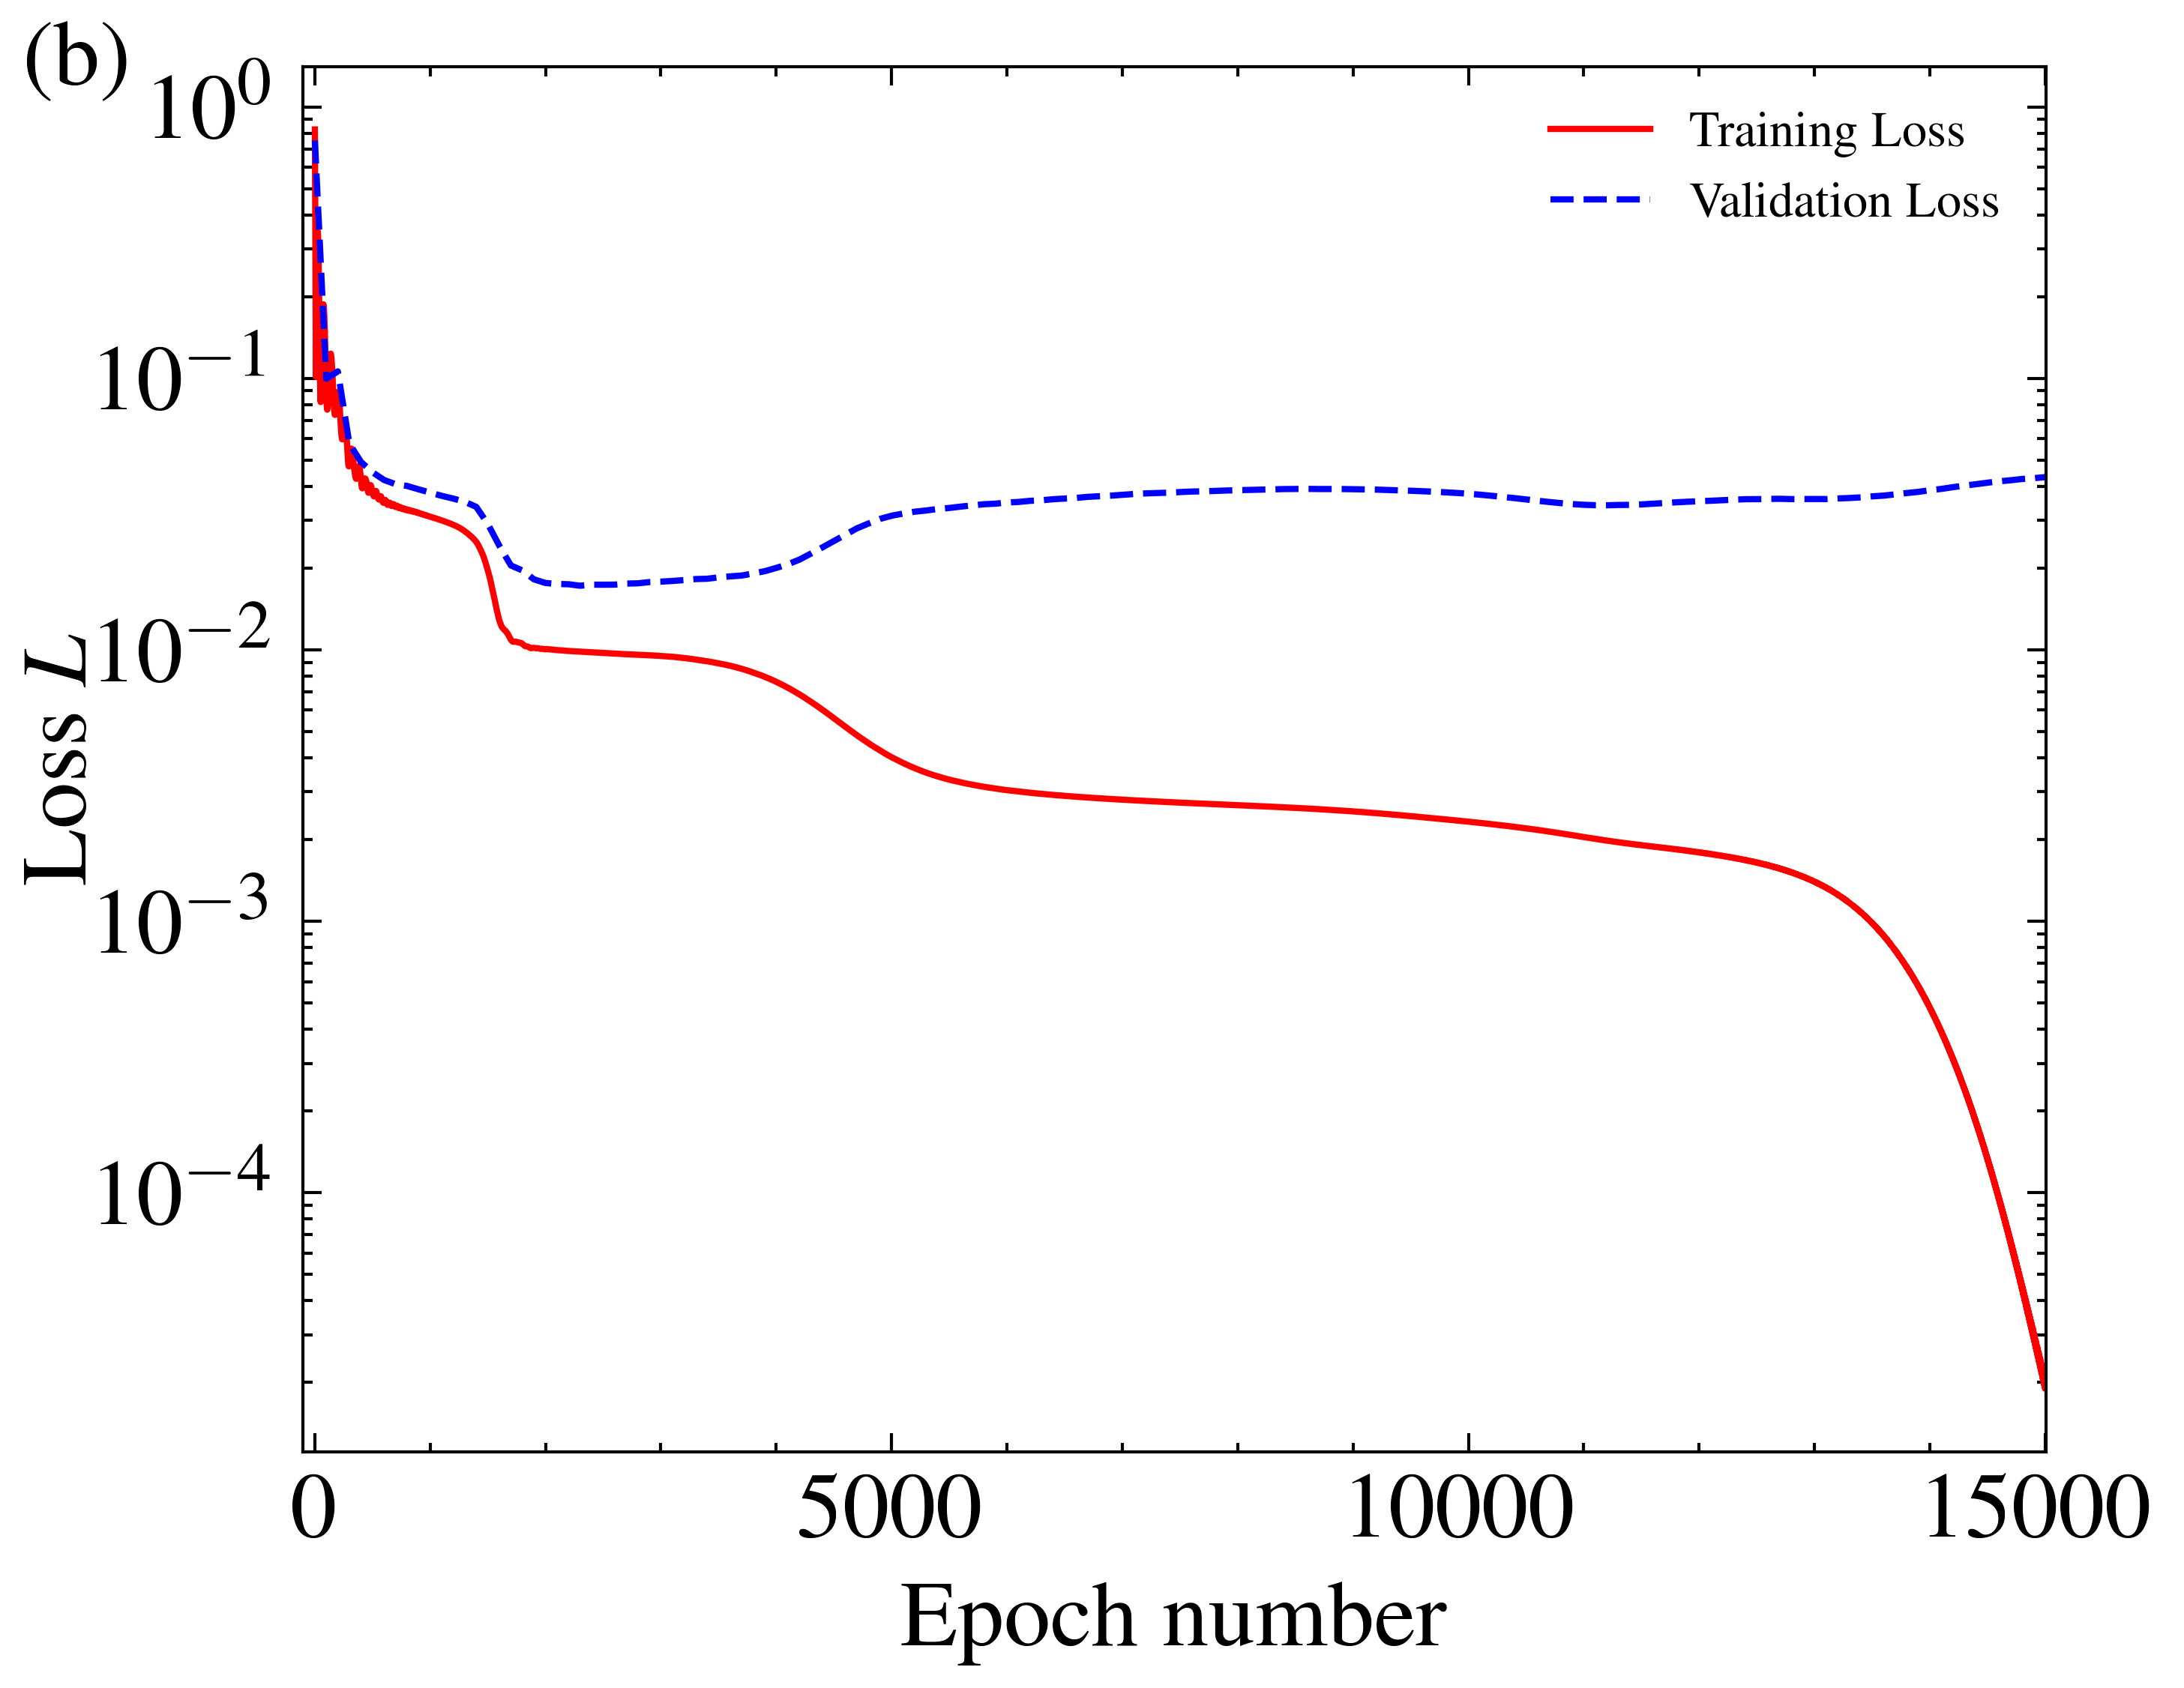

In [8]:
# 绘制训练和验证的loss曲线
plt.rcParams['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus'] = True
plt.style.use(['science', 'ieee'])

fig, ax = plt.subplots(figsize=(5, 4))
plt.cla()
plt.tick_params(labelsize=15)
ax.set_xlabel('Epoch number', fontsize=15)
ax.set_ylabel('Loss $L$', fontsize=15, labelpad=-1)
ax.set_xlim(-100, 15010)
ax.set_yscale('log')  # 设置y轴为对数坐标
ax.text(-2500, 1.2, '(b)', fontdict={'size': 15, 'color': 'black'})

ax.plot(range(1, epoch + 1), para0.numpy(), 'r-', lw=1, label='Training Loss')
ax.plot(validation_epochs, para1, 'b--', lw=1, label='Validation Loss')
#plt.savefig('D:/PLA2024/Fig2b.eps', format='eps')
plt.legend()
plt.show()

In [0]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scienceplots

# Configure plot settings
plt.rcParams['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus'] = True
plt.style.use(['science', 'ieee'])

# Generate figure and axis
fig, ax = plt.subplots(figsize=(5, 4))
plt.cla()
plt.tick_params(labelsize=15)
ax.set_xlabel('$x$', fontsize=15)
ax.set_ylabel('$y$', fontsize=15)
ax.set_xlim(-2.1, 10.1)
ax.set_ylim(-0.05, 1.6)

# Scatter plot for training set
ax.scatter(x.data.numpy(), y.data.numpy(), color="orange", label='noisy data')

# Generate input and output for the plot
input = torch.unsqueeze(torch.linspace(-2, 10, 401), dim=1)
output = net(input)

# Plot network fitting output
ax.plot(input.data.numpy(), output.data.numpy(), 'r-', lw=1, label='sigmoid network')

# True signal
signal = np.exp(-(input - 2)**2) + np.exp(-(input - 6)**2 / 10) + 1 / (input**2 + 1)
ax.plot(input.data.numpy(), signal.data.numpy(), 'b--', lw=1, label='signal')

# Save output to CSV file
# output_data = np.hstack((input.data.numpy(), output.data.numpy()))
# np.savetxt('D:/PLA2024/outputsigmoid.csv', output_data, delimiter=',', header='x,output', comments='')
ax.text(-4, 1.55, '(a)',fontdict={'size': 15, 'color':  'black'})
# Save figure as EPS file
#plt.savefig('D:/PLA2024/Fig2a.eps', format='eps')

# Show plot
plt.legend()
plt.show()

#如果修改的话，重新读取数据
# data = np.loadtxt('D:/PLA2024/outputsigmoid.csv', delimiter=',', skiprows=1)

# # 分割读取的数据
# input_data = data[:, 0]
# output_values = data[:, 1]

In [1]:

####
#第2部分我们用x数据中加噪声进行贝叶斯优化optuna
import random
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import optuna
from tqdm import tqdm
device = torch.device('cpu')
# Set initial seed
SEED = 1234
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True

# Define data
x = torch.unsqueeze(torch.linspace(-2, 10, 19), dim=1).to(device)
ytrain = np.exp(-(x - 2)**2) + np.exp(-(x - 6)**2 / 10) + 1 / (x**2 + 1) + 0.12 * torch.randn(x.size()).to(device)

# Define network
class Net(nn.Module):
    def __init__(self, n_feature, n_hidden1, n_output,noise=0.0):
        super(Net, self).__init__()
        self.hidden1 = nn.Linear(n_feature, n_hidden1)
        self.predict = nn.Linear(n_hidden1, n_output)
        self.noise = noise
    def forward(self, x):
        # 添加噪声到输入数据
        x = x + self.noise * torch.randn_like(x)
        x = torch.sigmoid(self.hidden1(x))
        return self.predict(x)

    def reset_parameters(self):
        self.hidden1.reset_parameters()
        self.predict.reset_parameters()

# Optimization objective
def objective(trial):
    noise = trial.suggest_float('noise', 0, 0.2)
    net = Net(n_feature=1, n_hidden1=14, n_output=1, noise=noise).to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.01, betas=(0.99, 0.99))
    loss_func = nn.MSELoss().to(device)

    NJnum = 10
    epoch = 15000
    train_losses = []

    for num in range(NJnum):
        seed = random.sample(range(1, 1000), 1)[0]#选择一个随机种子
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)

        net.reset_parameters()#每次实验前重置网络参数

        for _ in range(epoch):
            net.train()# 设定网络为训练模式
            prediction = net(x)
            loss = loss_func(prediction, ytrain)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_losses.append(loss.item()) # 记录本次训练的损失值

    train_loss = np.mean(train_losses) # 计算平均训练损失

    # Test phase
    seeds = random.sample(range(1, 1000), 10)
    test_losses = []

    for seed in seeds:
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        x_test = torch.unsqueeze(torch.linspace(-2, 10, 30), dim=1).to(device)
        y_test = np.exp(-(x_test - 2)**2) + np.exp(-(x_test - 6)**2 / 10) + 1 / (x_test**2 + 1) + 0.12 * torch.randn(x_test.size()).to(device)

        net.eval()# 设定网络为评估模式
        with torch.no_grad():
            prediction_test = net(x_test)
            test_loss = loss_func(prediction_test, y_test)
            test_losses.append(test_loss.item())

    mean_test_loss = np.mean(test_losses)

    return mean_test_loss

# Run optimization
study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(seed=SEED),  # Use TPE sampler with seed
    pruner=optuna.pruners.MedianPruner()  # Use median pruner for early stopping
)

study.optimize(objective, n_trials=20, show_progress_bar=True)

best_sigma = study.best_params["noise"]

[I 2024-07-06 11:06:46,213] A new study created in memory with name: no-name-17e2dd0e-1d7a-4958-8c31-fc18c8025834


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2024-07-06 11:08:14,557] Trial 0 finished with value: 0.019655227847397327 and parameters: {'noise': 0.03830389007577846}. Best is trial 0 with value: 0.019655227847397327.
[I 2024-07-06 11:09:41,236] Trial 1 finished with value: 0.020798539649695157 and parameters: {'noise': 0.12442175420796638}. Best is trial 0 with value: 0.019655227847397327.
[I 2024-07-06 11:11:17,289] Trial 2 finished with value: 0.018984668888151646 and parameters: {'noise': 0.0875455478014229}. Best is trial 2 with value: 0.018984668888151646.
[I 2024-07-06 11:12:49,363] Trial 3 finished with value: 0.02000897452235222 and parameters: {'noise': 0.15707171674275386}. Best is trial 2 with value: 0.018984668888151646.
[I 2024-07-06 11:14:17,730] Trial 4 finished with value: 0.023049780912697316 and parameters: {'noise': 0.1559951616237607}. Best is trial 2 with value: 0.018984668888151646.
[I 2024-07-06 11:15:43,730] Trial 5 finished with value: 0.018503518681973218 and parameters: {'noise': 0.05451852105652832

In [1]:
best_noise = study.best_params["noise"]
print(best_noise)
#Best noise: 0.04389331715913001

NameError: name 'study' is not defined

Best hyperparameter (sigma): 0.04389331715913001
Mean Test Loss: 0.024513751454651355
Mean Train Loss: 0.006445291824638844


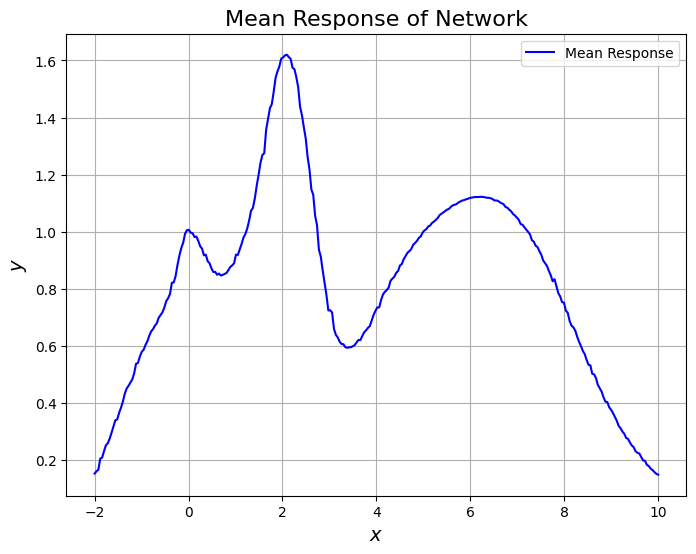

In [4]:
import random
import torch
import numpy as np
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt

# Define your neural network architecture
class Net(nn.Module):
    def __init__(self, n_feature, n_hidden1, n_output,noise=best_noise):
        super(Net, self).__init__()
        self.hidden1 = nn.Linear(n_feature, n_hidden1)
        self.predict = nn.Linear(n_hidden1, n_output)
        self.noise = noise
        
    def forward(self, x):
        # 添加噪声到输入数据
        x = x + self.noise * torch.randn_like(x)
        x = torch.sigmoid(self.hidden1(x))
        return self.predict(x)

     def reset_parameters(self):
        self.hidden1.reset_parameters()
        self.predict.reset_parameters()


# Initialize hyperparameters and network
net = Net(n_feature=1, n_hidden1=14, n_output=1,noise=best_noise).to(device)
optimizer = optim.Adam(net.parameters(), lr=0.01, betas=(0.99, 0.99))
loss_func = nn.MSELoss().to(device)

# Define training settings
NJnum = 10
epoch = 15000

# Placeholder for x and ytrain, replace with your data
x = torch.unsqueeze(torch.linspace(-2, 10, 19), dim=1).to(device)
ytrain = np.exp(-(x - 2)**2) + np.exp(-(x - 6)**2/10) + 1/ (x**2+1) + 0.12 * torch.randn(x.size()).to(device)

# Define x_respond for response plotting
x_respond = torch.unsqueeze(torch.linspace(-2, 10, 300), dim=1)

# Initialize lists to store losses and responses
train_losses = []
responses = []

# Training loop with noisy data
for num in range(NJnum):
    seed = random.sample(range(1, 10000), 1)[0]
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    net.reset_parameters()

    # Training loop
    for _ in range(epoch):
        net.train()
        prediction = net(x)
        loss = loss_func(prediction, ytrain)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Append the train loss
    train_losses.append(loss.item())

    # Calculate mean response for x_respond after training
    net.eval()
    with torch.no_grad():
        response = net(x_respond)
        responses.append(response.numpy())

# Calculate mean train loss
mean_train_loss = np.mean(train_losses)
# Calculate mean response across NJnum runs
mean_response = np.mean(responses, axis=0)

# Test phase
seeds = random.sample(range(1, 10000), 10)
test_losses = []

for seed in seeds:
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    x_test = torch.unsqueeze(torch.linspace(-2, 10, 30), dim=1).to(device)
    y_test = np.exp(-(x_test - 2)**2) + np.exp(-(x_test - 6)**2 / 10) + 1 / (x_test**2 + 1) + 0.12 * torch.randn(x_test.size()).to(device)

    net.eval()
    with torch.no_grad():
        prediction_test = net(x_test)
        test_loss = loss_func(prediction_test, y_test)
        test_losses.append(test_loss.item())

mean_test_loss = np.mean(test_losses)

print("Best hyperparameter (sigma):", best_noise)
print("Mean Test Loss:", mean_test_loss)
print("Mean Train Loss:", mean_train_loss)

# Plotting responses
plt.figure(figsize=(8, 6))
plt.plot(x_respond.numpy(), mean_response, label='Mean Response', color='blue')
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.title('Mean Response of Network', fontsize=16)
plt.grid(True)
plt.legend()
plt.show()

In [13]:
# 将 x_respond 和 mean_response 保存到 CSV 文件
x_respond_np = x_respond.numpy()
output_data = np.hstack((x_respond_np, mean_response))
np.savetxt('D:/PycharmProjects/保存的参数/FOrestes（1）mean_response.csv', output_data, delimiter=',', header='x,mean_response', comments='')


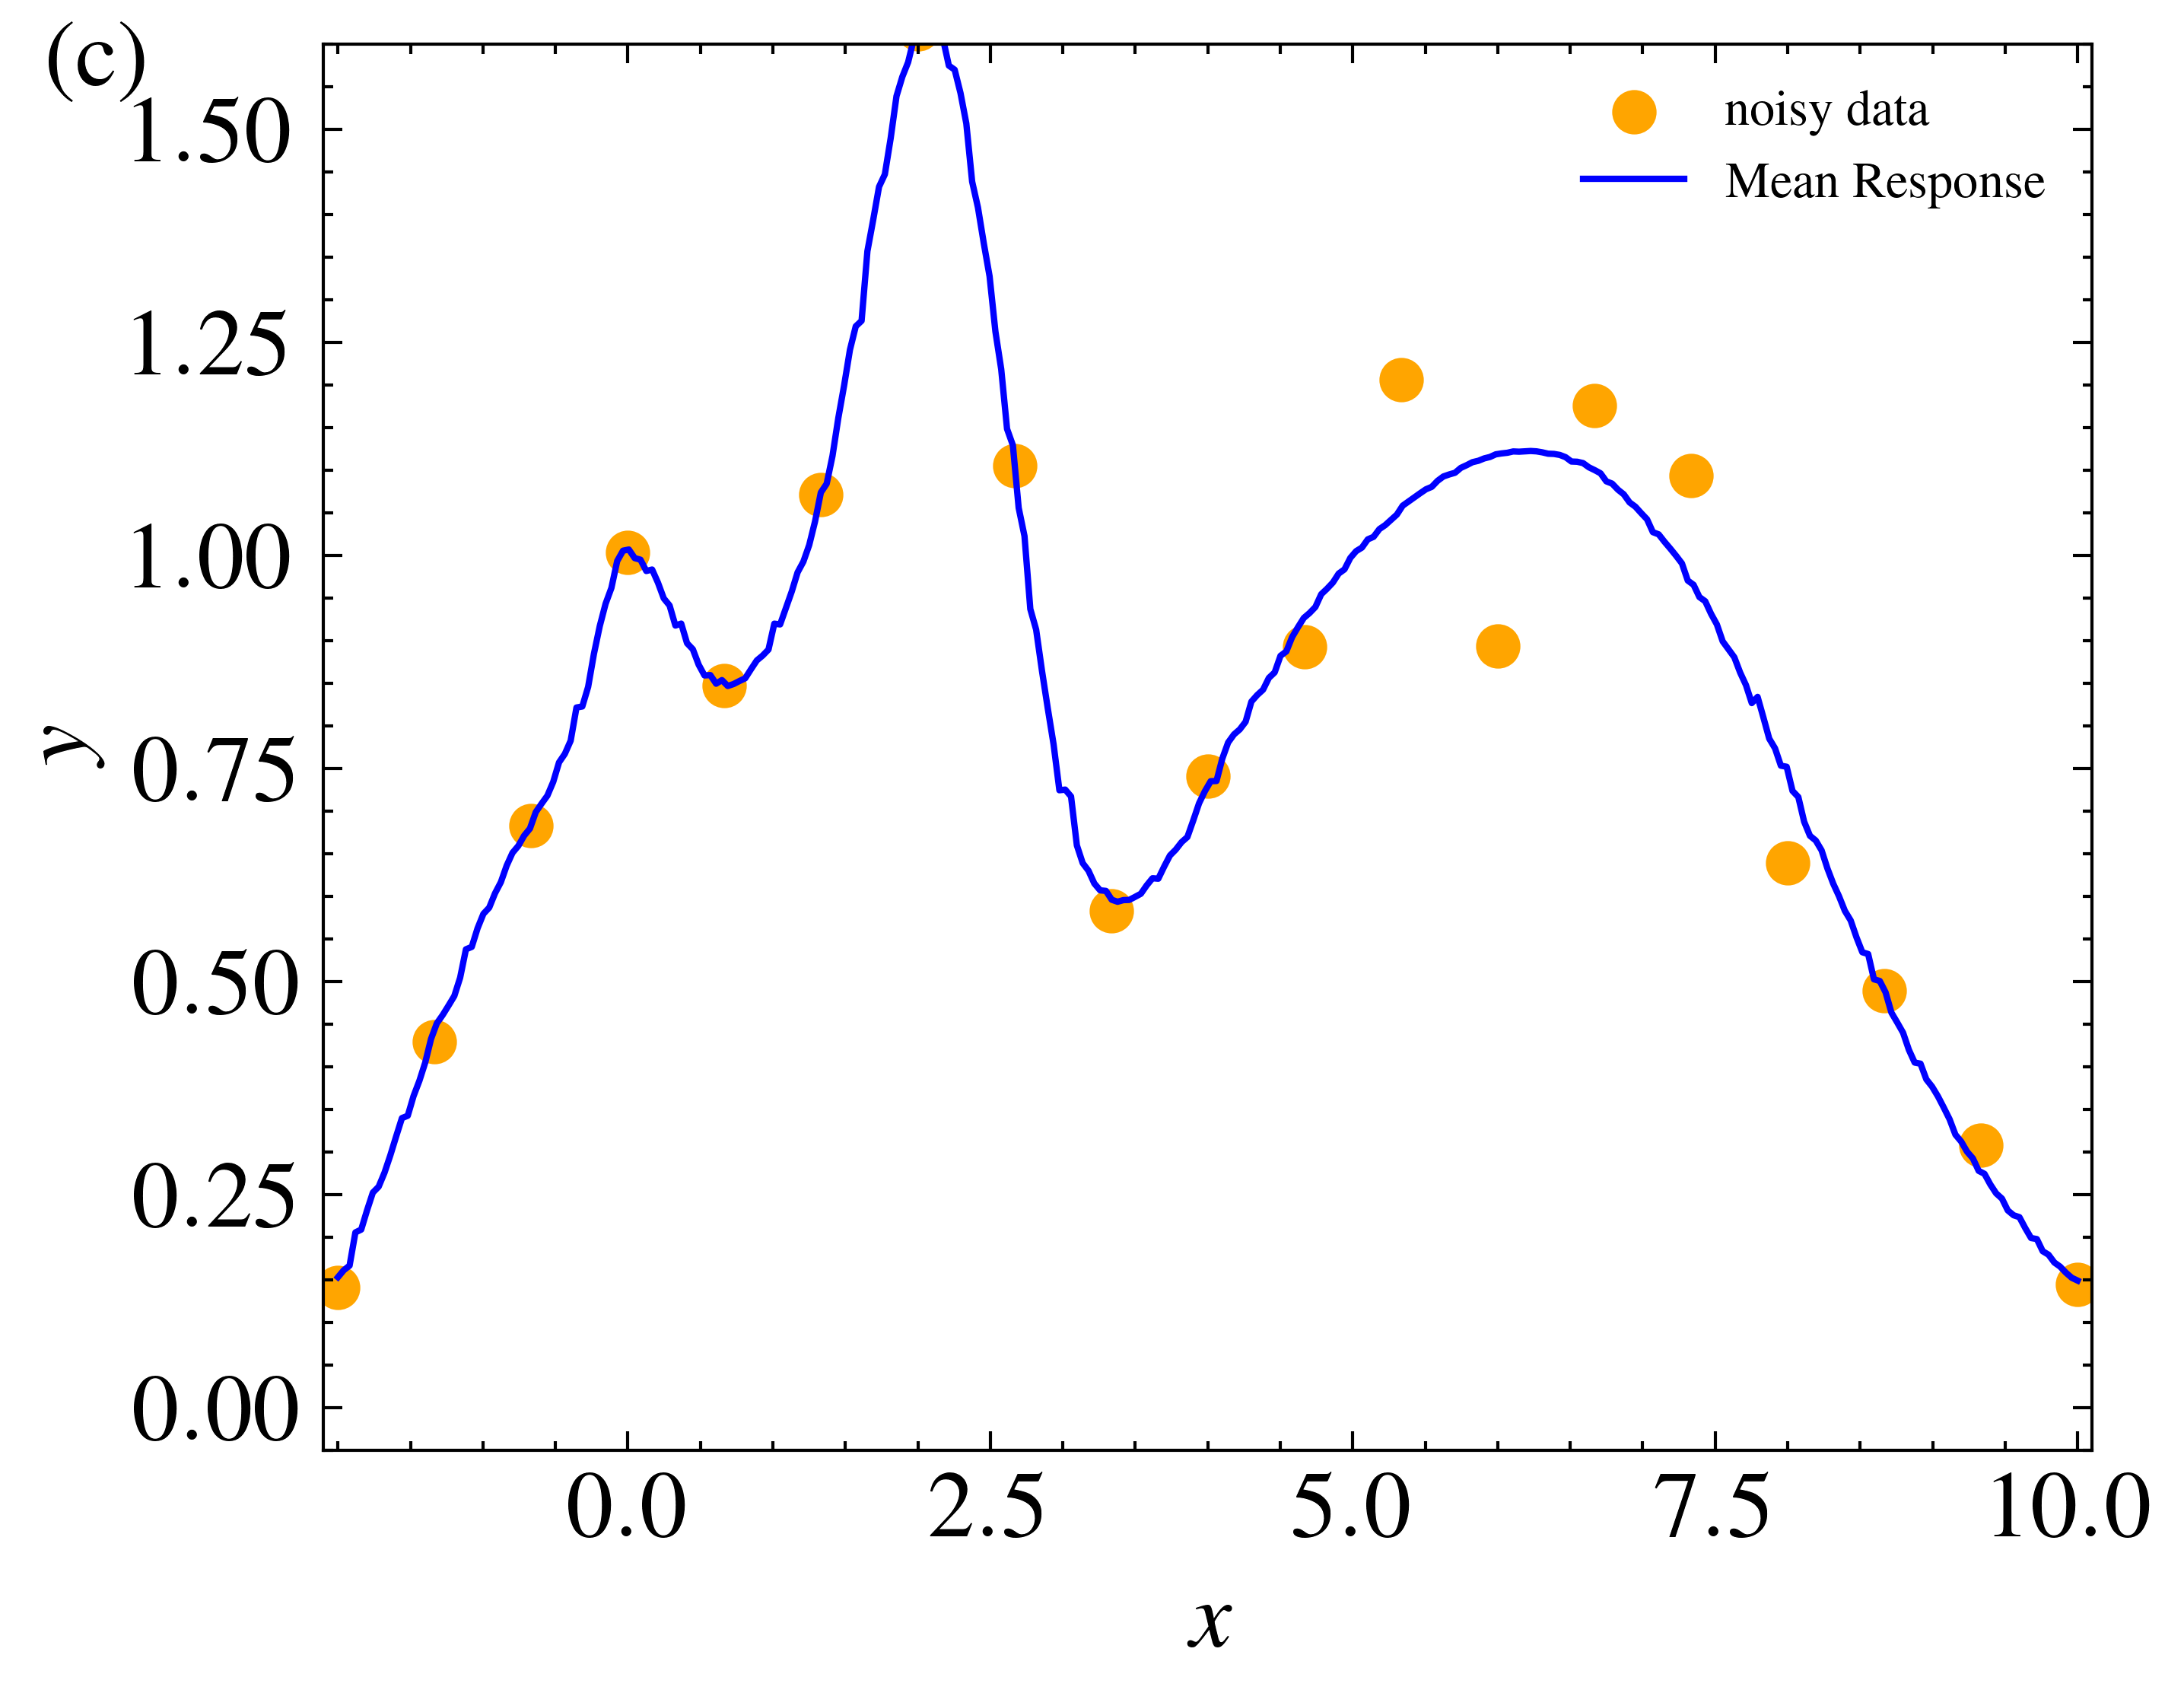

In [14]:
import matplotlib.pyplot as plt
import matplotlib as mpl
# Configure plot settings
plt.rcParams['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus'] = True
plt.style.use(['science', 'ieee'])
plt.rcParams['text.usetex'] = True
# Generate figure and axis
fig, ax = plt.subplots(figsize=(5, 4))
plt.cla()
plt.tick_params(labelsize=15)
ax.set_xlabel('$x$', fontsize=15)
ax.set_ylabel('$y$', fontsize=15)
ax.set_xlim(-2.1, 10.1)
ax.set_ylim(-0.05, 1.6)

# Scatter plot for training set
ax.scatter(x.data.numpy(), ytrain.data.numpy(), color="orange", label='noisy data')

plt.plot(x_respond.numpy(), mean_response, label='Mean Response', color='blue')


# Save output to CSV file
#output_data = np.hstack((inputx.data.numpy(), output.data.numpy()))
#np.savetxt('D:/PLA2024/outputsigmoidxnoise.csv', output_data, delimiter=',', header='x,output', comments='')
ax.text(-4, 1.55, '(c)',fontdict={'size': 15, 'color':  'black'})
# Save figure as EPS file
# Show plot
plt.legend()
# plt.savefig('D:/PLA2024/Fig2c.eps', format='eps')
plt.show()